# JLMT Python Implementation

**Object**

**Steps**:
1. Audio input
2. ANI

**Environment**:
- Python version: 3.9.0
- Platform: Win(Not support in Mac) 

# 0. Import required packages

In [5]:
import os

os.chdir(os.path.join(r"C:\Users\w1881\Desktop\Research\jlmt_python\src\c_code"))#Path way
import ipem_auditory_model


In [26]:
%cd C:\Users\w1881\Desktop\Research\jlmt_python\

C:\Users\w1881\Desktop\Research\jlmt_python


In [9]:
!pip install librosa numpy
!pip install matplotlib Cython

  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached numba-0.60.0-cp39-cp39-win_amd64.whl.metadata (2.8 kB)
  Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl.metadata (60 kB)
  Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl.metadata (15 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl.metadata (16 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-1.0.0-cp39-cp39-win_amd64.whl.metadata (5.6 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached msgpack-1.1.2-cp39-cp39-win_amd64.whl.metadata (8.4 kB)
  Using cached llvmlite-0.43.0-cp39-cp39-win_amd64.whl.metadata (4.9 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached charset_normalizer-3.4.4-cp3

In [10]:
# Setup and import required packages
import numpy as np
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt
import os
import librosa

import ipem_auditory_model #the c project imported by cython

# 1. Audio input and Auditory Nerve Image (ANI)
The current processing method is the same as MATLAB, by resampling to 22,050 Hz, adding 20 ms of silence before and after, calling C code to generate the .ani file, reading the .ani file and the filter frequency, downsampling and plotting.

In [11]:
#Audio input
def load_audio(path, mono=True, normalize=True):
    """
    Load and preprocess an audio file (wav or mp3). 
    
    Parameters: 
    path - Path to audio file 
    sr - Target sampling rate 
    mono - Convert to mono (sum channels) 
    normalize -  Normalize amplitude to [-1, 1].
    
    Returns: 
    y - Audio signal
    sr - Sampling rate
    """
    y, sr = librosa.load(path, mono=mono)
    if normalize:
        y = y / np.max(np.abs(y))
    
    return y.astype(np.float32), sr

In [ ]:
#Calculate ANI
def calc_ani(
    in_signal,
    in_sample_freq,
    in_auditory_model_path="./test_sound",
    downsampling_factor=1,
    num_channels=40,
    first_cbu=2.0,
    cbu_step=0.5,
):
    """
    Parameters
    in_signal : np.ndarray
        Input signal
    in_sample_freq : int or float
        Sampling rate (Hz)
    in_auditory_model_path : str
        Directory where auditory model will read/write temp files
    downsampling_factor : int
        Downsampling factor for the ANI (default = 4)
    num_channels : int
        Number of cochlear filter channels
    first_cbu : float
        Starting CBU
    cbu_step : float
        Step size in CBU between channels

    Returns
    out_ani : np.ndarray
        Auditory Nerve Image matrix (num_channels x time_frames)
    out_ani_freq : float
        Sampling rate of ANI (Hz)
    out_filter_freqs : np.ndarray
        Center frequencies (Hz)
    """

    print("Start of calc_ani...")

    # Input validation
    if in_signal.ndim > 1:
        if in_signal.shape[1] == 1:
            in_signal = in_signal[:, 0]
        else:
            raise ValueError("Can only process mono signals.")

    # Resample and pad
    new_sample_freq = 22050
    n_zeros = int(round(0.020 * new_sample_freq))  # 20 ms
    zeros_pad = np.zeros(n_zeros)

    if in_sample_freq != new_sample_freq:
        new_sound = signal.resample_poly(in_signal, new_sample_freq, in_sample_freq)
    else:
        new_sound = in_signal

    new_sound = np.concatenate([zeros_pad, new_sound, zeros_pad])

    # Write temp wav
    input_wav = os.path.join(in_auditory_model_path, "input.wav")
    sf.write(input_wav, new_sound, new_sample_freq, subtype="PCM_16")

    # Call auditory model
    output_ani = os.path.join(in_auditory_model_path, "nerve_image.ani")
    try:
        ipem_auditory_model.process_file(
            "input.wav",
            "nerve_image.ani",
            num_channels=40,
            first_freq=first_cbu,
            freq_dist=cbu_step,
            input_filepath=in_auditory_model_path,
            output_filepath='./',
            sample_frequency=new_sample_freq,
            sound_format='wav'
        )
    except Exception as e:
        raise RuntimeError(f"Error during ipem_process: {e}")

    # Read ANI data
    ani = np.fromfile(output_ani, sep=' ')
    out_ani = ani.reshape((num_channels, -1), order="F")

    # Read filter center frequencies (in kHz)
    filt_file = os.path.join(in_auditory_model_path, "FilterFrequencies.txt")
    if os.path.exists(filt_file):
        out_filter_freqs = np.loadtxt(filt_file) * 1000  # convert to Hz
    else:
        out_filter_freqs = np.linspace(200, 8000, num_channels)  # fallback

    # Remove silence padding
    out_ani = out_ani[:, int(n_zeros / 2):-int(n_zeros / 2)]

    # Downsample if needed
    out_ani_freq = new_sample_freq / 2
    if downsampling_factor != 1:
        out_ani = signal.resample_poly(out_ani.T, 1, downsampling_factor).T
        out_ani_freq /= downsampling_factor


    # Cleanup temp files
    for f in [
        "input.wav", "nerve_image.ani", "FilterFrequencies.txt",
        "decim.dat", "eef.dat", "filters.dat", "lpf.dat",
        "omef.dat", "outfile.dat"
    ]:
        fpath = os.path.join(in_auditory_model_path, f)
        if os.path.exists(fpath):
            os.remove(fpath)

    print("...end of calc_ani.")
    return out_ani, out_ani_freq, out_filter_freqs

In [14]:
#Ploting
def plot_multi_channel(
   data,
   sample_freq=1,
   title='',
   xlabel='',
   ylabel='',
   font_size=None,
   channel_labels=None,
   channel_label_step=1,
   min_y=None,
   max_y=None,
   plot_type=0,
   time_offset=0,
   y_scale_factor=1,
   channels=None,
   one_based_index=True
):
  
   if data is None or len(data) == 0:
       print("None")
       return
  
   n_rows, n_cols = data.shape


   if channel_labels is None:
       channel_labels = [i + 1 for i in range(n_rows)]


   if channels is not None:
       if one_based_index:
           channels = [ch - 1 for ch in channels]
       channels = [ch for ch in channels if 0 <= ch < n_rows]
       if not channels:
           raise ValueError("No valid channel index")


       data = data[channels, :]
       channel_labels = [channel_labels[i] for i in channels]
       n_rows = len(channels)


   if min_y is None:
       min_y = np.min(data)
   if max_y is None:
       max_y = np.max(data)


   time_scale = np.arange(n_cols) / sample_freq + time_offset
   scale = abs(max_y - min_y) / y_scale_factor if y_scale_factor != 0 else 1


   plt.figure(figsize=(10, 6))


   if plot_type in [0, 2]:
       height = 0.9
       offset = height / 2 if plot_type == 2 else 0


       for i in range(n_rows):
           y_vals = i + height * (data[i, :] - min_y) / scale - offset
           plt.plot(time_scale, y_vals, linewidth=0.8)
      
       plt.ylim(1 - offset - 0.1, n_rows + height - offset + 0.1)
       plt.xlim(time_scale[0], time_scale[-1])


   elif plot_type == 1:
       plt.imshow(data, aspect='auto', origin='lower',
                  extent=[time_scale[0], time_scale[-1], 1, n_rows],
                  cmap='gray_r')
   else:
       raise ValueError("Unsupported plot_type (must be 0, 1, or 2)")


   if channel_label_step == -1:
       plt.yticks(np.arange(1, n_rows + 1), channel_labels)
   else:
       ticks = np.arange(0, n_rows, channel_label_step)
       plt.yticks(ticks + 1, [channel_labels[i] for i in ticks])


   plt.xlabel(xlabel)
   plt.ylabel(ylabel)
   plt.title(title)


   if font_size:
       plt.xticks(fontsize=font_size - 2)
       plt.yticks(fontsize=font_size - 2)
       plt.title(title, fontsize=font_size)


   plt.tight_layout()
   plt.show()


In [19]:
# Load audio
y, sr = load_audio("./test_sound/SchumannKurioseGeschichte.wav")
# Calc ANI
ani, ani_freq, freqs = calc_ani(y, sr, "./")
print("ANI shape:", ani.shape)
print("ANI sample rate:", ani_freq)
print("Filter freqs:", freqs[:5], "...")

Start of calc_ani...
...end of calc_ani.
ANI shape: (40, 60658)
ANI sample rate: 11025.0
Filter freqs: [141. 178. 215. 252. 291.] ...


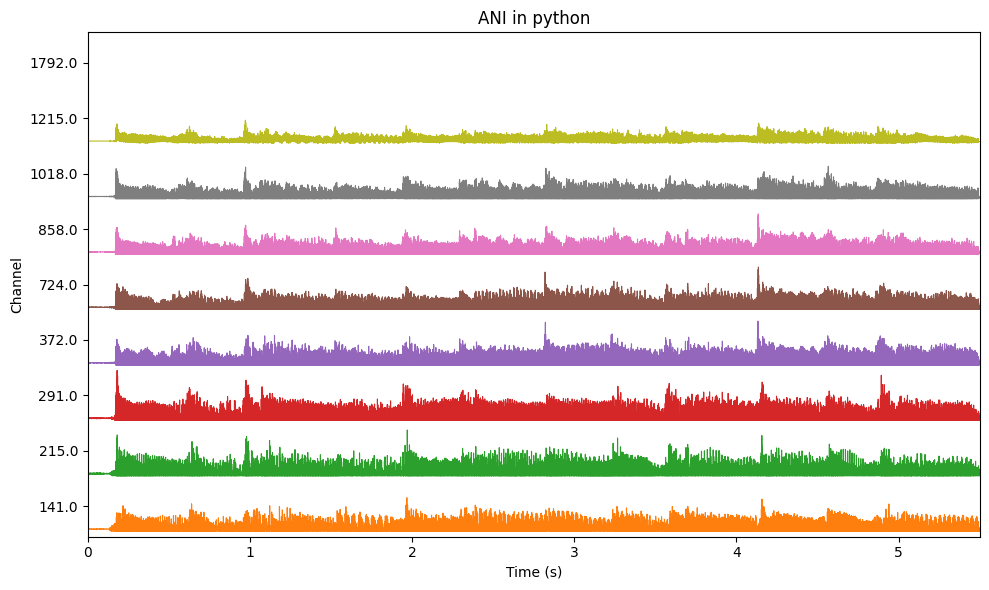

In [31]:
# Polt
plot_multi_channel(
   ani,
   sample_freq=ani_freq,
   title='ANI in python',
   xlabel='Time (s)',
   ylabel='Channel',
   font_size=12,
   channel_labels=freqs,
   channels=[1, 3, 5, 7, 14, 16, 18, 20, 24],#[1, 3, 5, 7, 14, 16, 18, 20, 24],
   plot_type=2
)


# 3. Periodicity Pitch (PP)

In [28]:
# Input the ANI
def calc_ani(
    temp_path = ".\test_sound\temp_file",
    downsampling_factor=1,
    num_channels=40,
    new_sample_freq = 22050
):

    print("Start of calc_ani...")
    n_zeros = int(round(0.020 * new_sample_freq))
    output_ani = os.path.join(temp_path, "nerve_image.ani")
    filt_file = os.path.join(temp_path, "FilterFrequencies.txt")

    ani = np.fromfile(output_ani, sep=' ')
    out_ani = ani.reshape((num_channels, -1), order="F")

    if os.path.exists(filt_file):
        out_filter_freqs = np.loadtxt(filt_file) * 1000
    else:
        print("Warning: FilterFrequencies.txt missing, using linear fallback.")
        out_filter_freqs = np.linspace(200, 8000, num_channels)
    out_ani = out_ani[:, int(n_zeros / 2):-int(n_zeros / 2)]

    out_ani_freq = new_sample_freq / 2
    if downsampling_factor != 1:
        out_ani = signal.resample_poly(out_ani.T, 1, downsampling_factor).T
        out_ani_freq /= downsampling_factor

    print("...end of calc_ani.")
    return out_ani, out_ani_freq, out_filter_freqs


In [29]:
ani, ani_fs, freqs = calc_ani(
    temp_path = r".\test_sound\temp_file",
    downsampling_factor=1,
    num_channels=40,
    new_sample_freq = 22050
)

Start of calc_ani...
...end of calc_ani.


# 4. Leaky Integration and Context image(CI)

# 5. Tonal Space (TS)

In [ ]:
#pipeline
def run_pipeline(audio_path):
    y, sr = load_audio(audio_path)

    ani = calc_ani(y, sr)
    pp  = calc_pp(ani)
    li  = leaky_integrate(pp)
    ts  = calc_tonal_space(y, sr)

    return {"ANI": ani, "PP": pp, "LI": li, "TS": ts}